<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Bayesian split test analysis using `pymc3`

Week 10 | 5.1

---

A common application of Bayesian analysis in industry is the analysis of split tests. For every product you use (espcially tech products) it is likely that you are part of a split test. Split tests are incrementally different versions of a product that are being tested on randomly selected users and evaluated on a performance metric. They are a great way to assess whether a proposed change will be beneficial, detrimental, or have no effect.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import patsy

Couldn't import dot_parser, loading of dot files will not be possible.


---

### Load fitness app split test conversions data

The dataset below contains information on user "conversions" on a fitness app on different "arms" of a split test. 

[A "conversion"](https://en.wikipedia.org/wiki/Conversion_marketing) is jargon for whether or not a user performed a desired action or not, typically a purchase.

"Arms" are the jargon for the different versions of a product in a currently running split test. Split tests are also commonly referred to as [A/B tests](https://en.wikipedia.org/wiki/A/B_testing), where A and B denote arms in the test.

---

#### Data description

The data has 6 columns:

    arm: the version of the app this user was randomly assigned to
    gender: male/female
    age: age bins, one of 20-30, 30-40, 40-50
    day: the day (total of 21 days)
    fitness: the user's self reported fitness level from -5 to 5
    converted: 1 if the user purchased the product, 0 if not
    
Each row is a unique user. 


In [5]:
data = pd.read_csv('../../../datasets/bayes_split_test/split_test_data.csv')
data['male'] = data.gender.map(lambda x: 1 if x == 'male' else 0)

In [6]:
data.head()

,arm,gender,age,day,fitness,converted,male
0,A,female,20-30,0,-2.0,0,0
1,A,female,40-50,0,3.0,0,0
2,A,female,30-40,0,-5.0,0,0
3,A,female,20-30,0,-4.0,0,0
4,A,male,30-40,0,1.0,1,1


---

### 1.1 Examine the split test arm "schedule"

When a new arm is introduced into a split test, it is generally tested at a low percentage of users initially before assignment becomes balanced between the arms. This ensures that if something is terribly wrong with one of the arms it does not ruin the experience for many potential customers.

Find the counts assigned to each split test arm by day.

In [7]:
arms_days = data[['arm','day']]
arms_days.groupby('day')['arm'].value_counts()

day  arm
0    A      26
1    A      40
     B       4
2    A      30
     B       3
3    A      30
     B       3
4    A      18
     B      18
5    A      15
     B      15
6    A      16
     B      16
7    A      17
     B      17
8    A      14
     B      14
     C       3
9    A      19
     B      19
     C       4
10   A      12
     B      12
     C       3
11   A       9
     B       9
     C       9
12   A      10
     B      10
     C      10
13   A      15
     B      15
     C      15
14   A      12
     B      12
     C      12
15   A      12
     B      12
     C      12
16   A      11
     B      11
     C      11
17   A      11
     B      11
     C      11
18   A      14
     B      14
     C      14
19   A      12
     B      12
     C      12
20   A      13
     B      13
     C      13
Name: arm, dtype: int64

---

### 1.2 Look at mean conversion rate overall and by arm

In [8]:
data.converted.mean()

0.17517241379310344

In [9]:
data.groupby('arm')['converted'].agg(np.mean) # == .mean()

arm
A    0.185393
B    0.116667
C    0.255814
Name: converted, dtype: float64

### 1.3 Look at overall conversion rate differences along age, gender, and fitness

In [10]:
data.groupby('age')['converted'].agg(np.mean)

age
20-30    0.253112
30-40    0.155738
40-50    0.116667
Name: converted, dtype: float64

In [11]:
data.groupby('gender')['converted'].agg(np.mean)

gender
female    0.206897
male      0.145889
Name: converted, dtype: float64

In [12]:
data.groupby('fitness')['converted'].agg(np.mean)

fitness
-5.0    0.055556
-4.0    0.026316
-3.0    0.073171
-2.0    0.148649
-1.0    0.086957
 0.0    0.179487
 1.0    0.161290
 2.0    0.171053
 3.0    0.276923
 4.0    0.391892
 5.0    0.484848
Name: converted, dtype: float64

In [13]:
data.shape

(725, 7)

---


## 2. Model conversion rates through day 5 with `pymc3`

We will start by just modeling the conversion rate distributions for arms A and B through day 5. At day 5, arm C has still not been introduced yet and so there are just 2 arms.

### 2.1 Subset the data to the first 5 days

In [14]:
current = data[data.day < 5]
print current.shape, current.arm.unique()

(172, 7) ['A' 'B']


In [15]:
current.groupby('arm')['converted'].agg(np.mean)

arm
A    0.180556
B    0.107143
Name: converted, dtype: float64

---

### 2.2 Set up a `pymc3` model and uniform priors for the probabilities of conversion for arms A and B

Recall that `pymc3` uses the `with ...` syntax for defining models. The first step in setting up a new model is to define the model as the "context" like so:

>```python
with pm.Model() as day5_model:
    #
```

We are going to model the _probability distributions for conversion rates for arms A and B._ As always with Bayesian statistics, we need to define prior distributions for our belief about these probabilities/rates of conversion per arm.

Let's say we have no belief whatsoever about rates, and so we will set an uninformative, flat priors over probabilities from 0 to 1 for both arms. This is equivalent to saying that we believe all conversion rates to be equally likely for both arms.

The syntax for setting up this flat prior is:

>```python
arm_A_prior = pm.Uniform('A_prior', lower=0, upper=1)
```

Set up the priors for both arms inside the `with ...` model block.

In [16]:
with pm.Model() as day5_model:
    A_prob = pm.Uniform('A_prob', lower=0, upper=1)
    B_prob = pm.Uniform('B_prob', lower=0, upper=1)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.


---

### 3.2 Set up `pm.Bernoulli` distributions to model conversions for arms A and B

Now that you've initialized your model, your `with` statements will be

>```python
with day5_model:
    #
```

Be careful not to re-define the model with `pm.Model()` or it will wipe the uniform priors you set before!

We are now going to set up the "likelihood" portion of the model. This is going to model the $P(data\;|\;\theta)$ part of Bayes theorem.

Our conversions are represented by a vector of 1s and 0s denoting whether or not the user converted or not. This is known as a "Bernoulli" process and pymc3 has an approprite function to handle it:

>```python
A_conversions = pm.Bernoulli('A_conversions', p=arm_A_prior, observed=arm_A_conversions)
```

`p=` is set to the prior for the arm that you defined in the last section. 

`observed=` should be set to the `converted` values for that arm specifically in the data.

By giving it an `observed` parameter, we are telling pymc3 that we want this to evaluate the likelihood of our data (the conversions) against models represented by the `p=` probability argument. We assign `p=` to be our prior belief about conversion rates for that arm because we want to update this belief (convert to posterior) based on the conversion data we have observed for that arm.

In [17]:
with day5_model:
    
    A_obs = pm.Bernoulli('Aobs', p=A_prob, observed=current[current.arm =='A'].converted.values)
    B_obs = pm.Bernoulli('Bobs', p=B_prob, observed=current[current.arm =='B'].converted.values)

---

### 3.3 Fit the model using MCMC

Now that we've set up the prior distributions and likelihoods, we can actually fit the model.

Below is code that will run MCMC on the model we have parameterized:

>```python
with day5_model:
    # obtain decent starting values via the find_MAP() function:
    start = pm.find_MAP()
    # construct the "trace" variable that holds samples from MCMC for all of our distributions:
    trace = pm.sample(10000, start=start)
```

Again you use the context `with day5_model:` to run code for your model.

`start = pm.find_MAP()` will try to find a good starting point for the MCMC sampling process. This means that your model will converge on the "likely" area much faster (though it makes the fitting slower initially).

`trace = pm.sample(10000, start=start)` uses the sampling method in pymc3 to perform 10,000 MCMC sampling iterations. This will automatically assign the NUTS sampler for you, which is more advanced but slower than the Metropolis-Hastings sampling we covered in class. The dataset is small so the speed shouldn't be too bad.

When this completes, the `trace` variable now contains the MCMC posterior samples for the distributions we specified while constructing the model.

>```python
# We defined our arm A prior distribution to be uniform and named it 'arm_A_prior'. 
# The pm.sample() procedure converted this into our posterior belief for the rate
# of conversions in arm A. You can access these posterior samples using the name
# you gave the variable when you created it:
#
trace['arm_A_prior']
#
# this will be a vector of values that are different potential rates of conversion
# for arm A. A histogram of these rates defines, roughly, the posterior probability
# distribution for the arm A rates after we consider the data we have collected.
```

In [37]:
with day5_model:
    trace = pm.sample(10000)

Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
100%|██████████| 10000/10000 [00:05<00:00, 1719.52it/s]


---

### 3.4 Use `pm.traceplot` to look at your posterior distributions

The `pm.traceplot()` function accepts the trace variable from your model sampling and will plot out the posterior distributions for all of the distributions you defined. 

It is common practice to get rid of a portion of the first samples, since those are probably weird values, especially with an uninformative prior. After some iterations the MCMC sampling procedure will make it's way to the "likely" area. Getting rid of some of the first values is called a "burn-in".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125e2aa50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123201750>]], dtype=object)

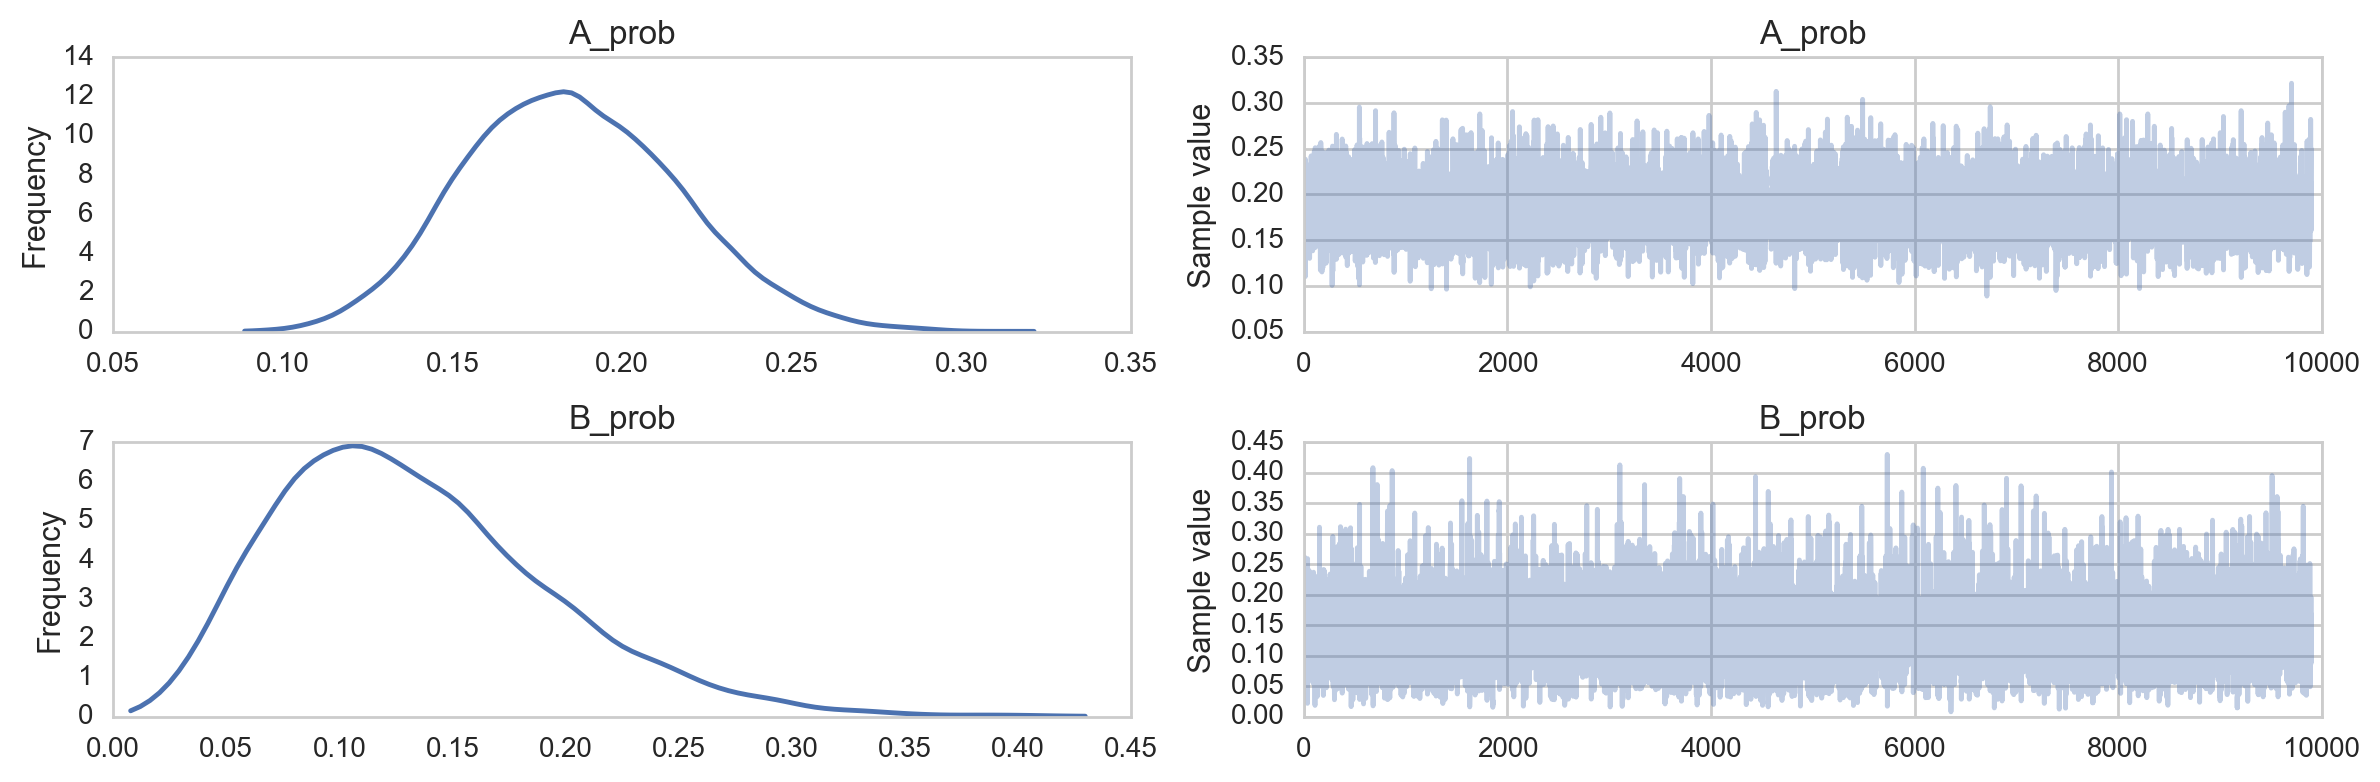

In [38]:
pm.traceplot(trace[100:])

In [39]:
import scipy.stats as stats

In [40]:
A_win = current[current.arm == 'A'].converted.sum()
A_lose = current[current.arm == 'A'].shape[0] - A_win
print A_win, A_lose

43 194


In [41]:
B_win = current[current.arm == 'B'].converted.sum()
B_lose = current[current.arm == 'B'].shape[0] - B_win
print B_win, B_lose

13 108


In [42]:
A_beta = stats.beta(A_win+1, A_lose+1)
B_beta = stats.beta(B_win+1, B_lose+1)

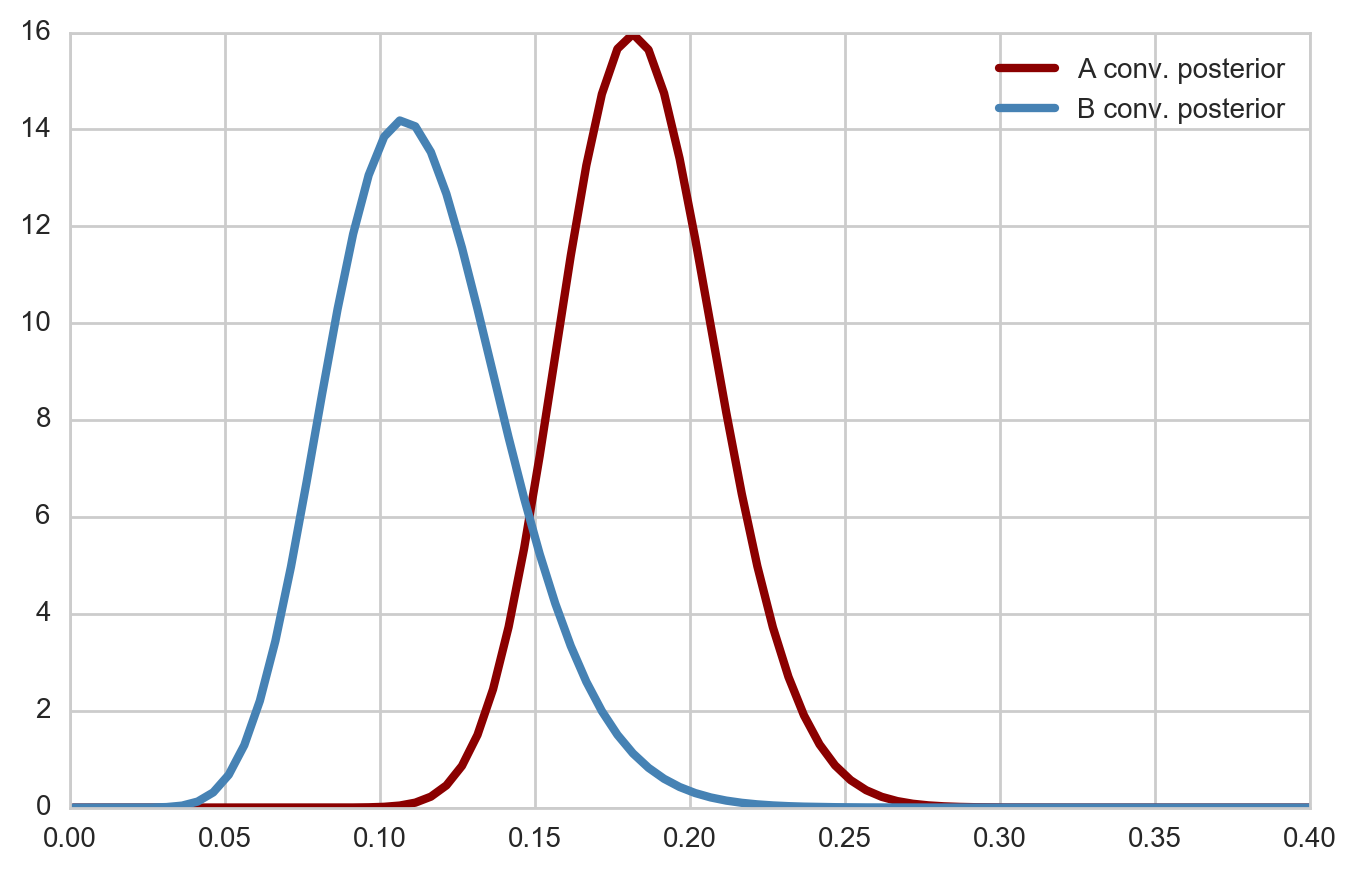

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
possible_conversion_rates = np.linspace(0.001, 0.999, 200)
ax.plot(possible_conversion_rates, A_beta.pdf(possible_conversion_rates), lw=3, color='darkred', label='A conv. posterior')
ax.plot(possible_conversion_rates, B_beta.pdf(possible_conversion_rates), lw=3, color='steelblue', label='B conv. posterior')
ax.legend(loc='upper right')
ax.set_xlim([0, 0.4])
plt.show()

In [44]:
# sample diff's b/w arm posteriors:
AvB_samples = []
for i in range(1000):
    a_rate = A_beta.rvs()
    b_rate = B_beta.rvs()
    AvB_samples.append(a_rate - b_rate)

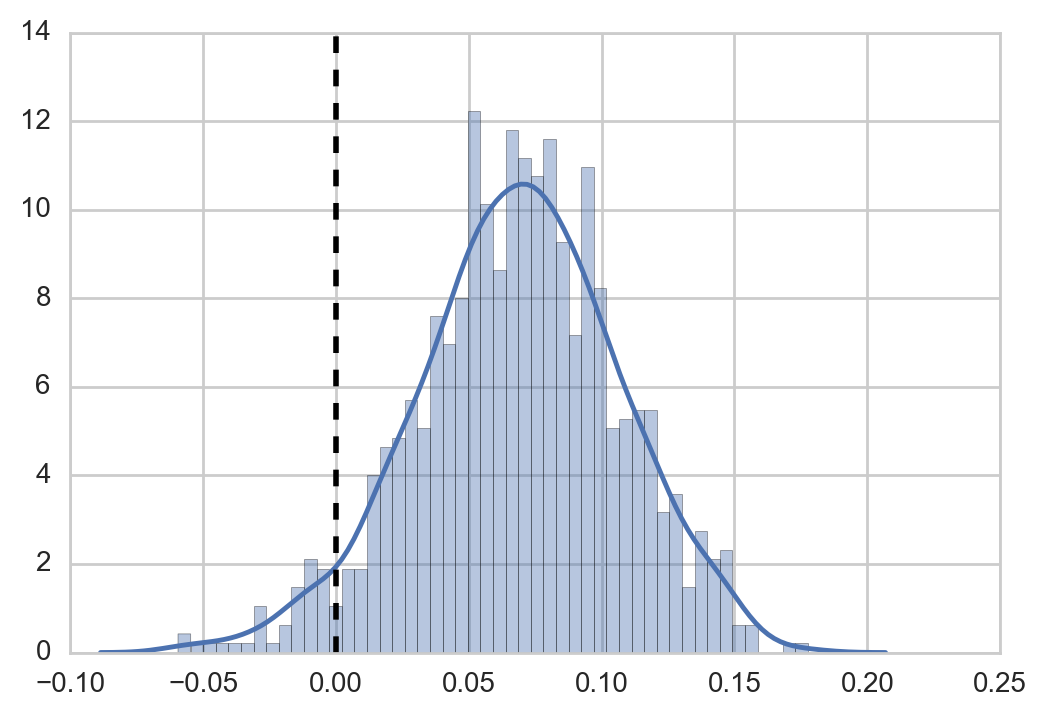

In [45]:
ax = sns.distplot(AvB_samples, bins=50)
ax.axvline(0, lw=2, color='black', ls='dashed')

In [46]:
AvB_samples = np.array(AvB_samples)
print float(np.sum(AvB_samples > 0))/AvB_samples.shape[0]

0.955


---

### 3.5 Write a function to plot your data distributions using `sns.distplot`

Your function should:

**1. Accept the "trace" values to plot as an argument.**

Say you had defined a prior

>```python
A_p = pm.Uniform('A_prob', lower=0, upper=1)
```

and then fit the model using `pm.sample(...)` like so

>```python
with model:
    # first obtain good starting values via MAP
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)
```

The `trace` variable now contains the samples of your posterior distribution for `A_prob` (and every other prior distribution that was converted to a posterior during the sampling process). You can access the values like so:

>```python
A_prob_trace_values = trace['A_prob']
```

You'll typically want to discard a portion of the starting MCMC samples as the process may still be searching for the "likely" area during that start-up period:

>```python
A_prob_trace_values = trace[1000:]['A_prob']
```

**2. Accept a list of names to label each trace.**

**3. Plot the traces on the same axis using `sns.distplot(...)` with `kde=True` in different colors for each distribution.**

You can pass an existing axis as a keyword argument into the function: `sns.distplot(..., ax=ax)` and it will plot the distribution on the existing axis.

**4. Have a legend that labels the distributions.**

The distplot function also accepts a label argument: `sns.distplot(..., label=label)`

To show the legend, you can use `ax.legend(loc='upper right')` or whatever location you think looks best.

---

### 3.6 Re-build the same model, but add a `pm.Deterministic` variable that calculates the difference between A and B conversion rates

For example, if I have two priors

>```python
A_p = pm.Uniform('A_prob', lower=0, upper=1)
B_p = pm.Uniform('B_prob', lower=0, upper=1)
```

I can set up a "deterministic" variable that is some specific calculation I want to do on each iteration of the MCMC sampling process

>```python
AvB = pm.Deterministic('AvB', A_p - B_p)
```

This will be a distribution with the differences between `A_p` and `A_b` on each sampling iteration; a posterior of the differences.

Recreate the model we built and ran above, but add the determinisic variable in the model definition before you do the sampling procedure.

### 3.7 Plot the posterior of the differences between arms using `pm.plot_posterior`

You can specify in `varnames` which posterior distribution you want to plot from your trace using the function, like so:

>```python
pm.plot_posterior(trace[5000:], varnames=['AvB'], color='#87ceeb', ref_val=0.)
```

In the above example, `ref_val=0` will plot a bar at 0 on the x-axis, which is useful for visualizing the proportion of the distribution of differences does not contain 0.

---

### 3.8 Based on the posterior distribution of differences, what can you say about the split test arms?

[The HPD is a measurement of the credible interval.](https://en.wikipedia.org/wiki/Credible_interval)

In [47]:
#

---

## 4. Perform the same analysis through day 8

We are going to do the same model-buidling process we went through above, but now on the data through day 8.

Subset to just the first 8 days.

---

### 4.1 Build and fit the day 8 model

This will be the same specification as your model for day 5. Keep the deterministic distribution that models the differences between arm A's rate and arm B's rate that we added in the second half of question 3.

---

### 4.2 Plot the traces with `pm.traceplot`

---

### 4.3 Plot the posterior distributions for arms A and B with your custom function

---

### 4.4 Plot the posterior distribution of differences between A and B with `pm.plot_posterior`

---

## 5. Perform the same type of analysis through day 11

**THERE ARE NOW 3 ARMS: A, B, and C!**

---

### 5.1 Build and fit the model

You will now need to add in capability for handling the third arm into the model.

You should also now calculate 3 "deterministic" variables that look at differences between the three arms:

- `A` vs. `B`
- `A` vs. `C`
- `B` vs. `C`

In [48]:
current = data[data.day < 11]
print current.shape, current.arm.unique()

(368, 7) ['A' 'B' 'C']


In [49]:
with pm.Model() as day11_model:
    
    A_p = pm.Uniform('A_prob', lower=0, upper=1)
    B_p = pm.Uniform('B_prob', lower=0, upper=1)
    C_p = pm.Uniform('C_prob', lower=0, upper=1)
    
    A = pm.Bernoulli('A', p=A_p, observed=current[current.arm == 'A'].converted.values)
    B = pm.Bernoulli('B', p=A_p, observed=current[current.arm == 'B'].converted.values)
    C = pm.Bernoulli('C', p=A_p, observed=current[current.arm == 'C'].converted.values)
    
    AvB = pm.Deterministic('AvB', A_p - B_p)
    AvC = pm.Deterministic('AvC', A_p - C_p)
    BvC = pm.Deterministic('BvC', B_p - C_p)
    
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to A_prob and added transformed A_prob_interval_ to model.
Applied interval-transform to B_prob and added transformed B_prob_interval_ to model.
Applied interval-transform to C_prob and added transformed C_prob_interval_ to model.
Assigned NUTS to A_prob_interval_
Assigned NUTS to B_prob_interval_
Assigned NUTS to C_prob_interval_
100%|██████████| 10000/10000 [00:08<00:00, 1121.43it/s]


---

### 5.2 Plot the distributions for the arms using your custom function

In [50]:
def plot_betas(beta_traces, beta_names, colors=['steelblue','darkred','goldenrod']):
    fig, ax = plt.subplots(figsize=(9,5))
    for i, bn in enumerate(beta_names):
        ax = sns.distplot(beta_traces[i], kde=True, color=colors[i], label=bn)
    ax.legend(loc='upper right')
    plt.show()

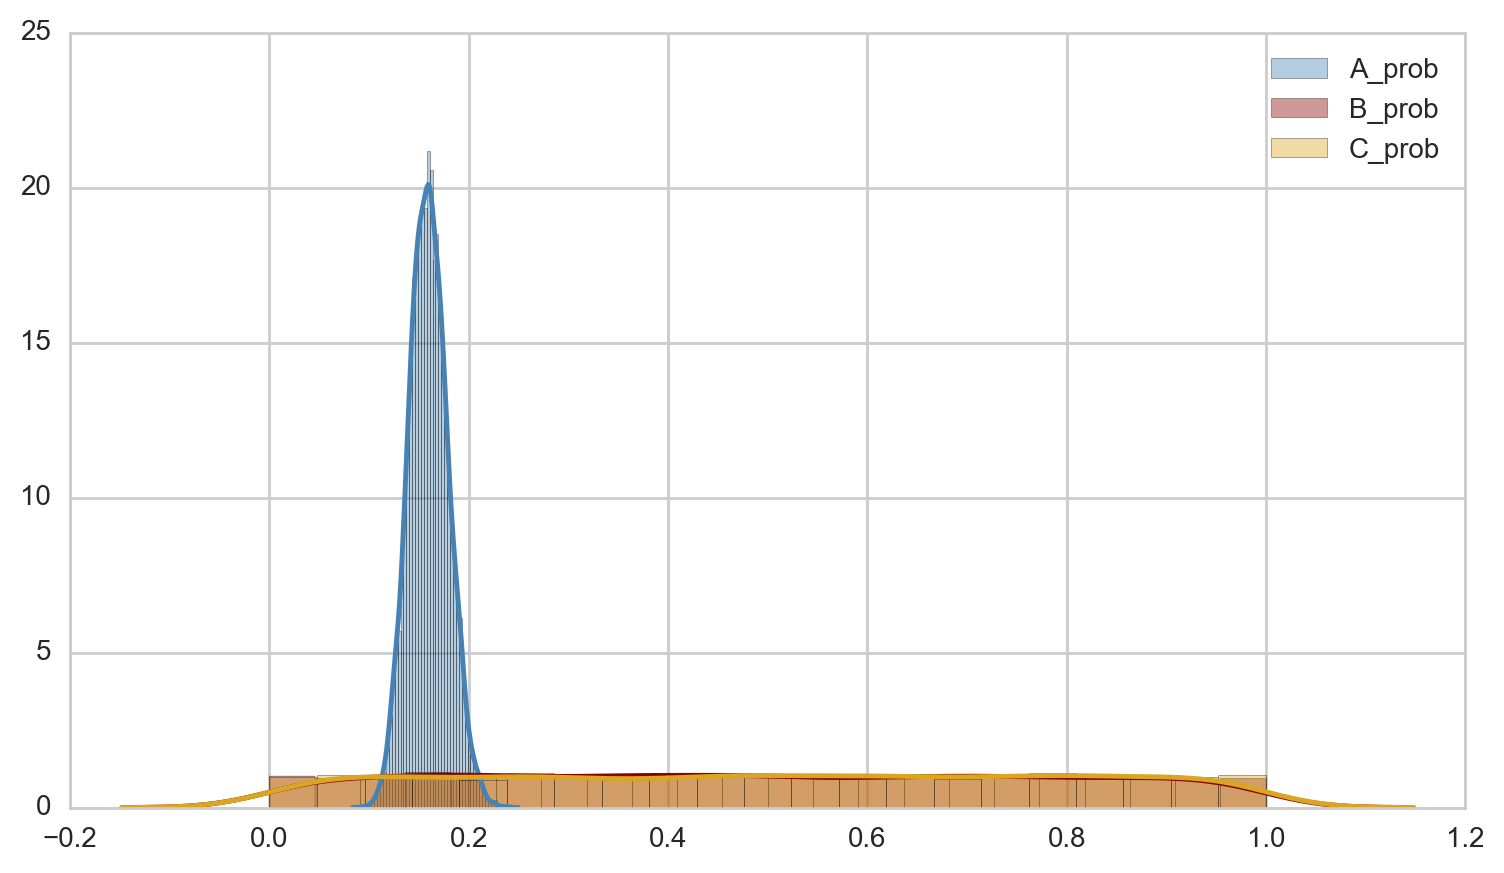

In [53]:
arm_traces = [trace[1000:][arm] for arm in ['A_prob', 'B_prob','C_prob']]
plot_betas(arm_traces, ['A_prob', 'B_prob','C_prob'])

---

### 5.3 Plot the three difference measure posterior distributions using `pm.plot_posterior`

array([<matplotlib.axes._subplots.AxesSubplot object at 0x133006190>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x139ce0510>], dtype=object)

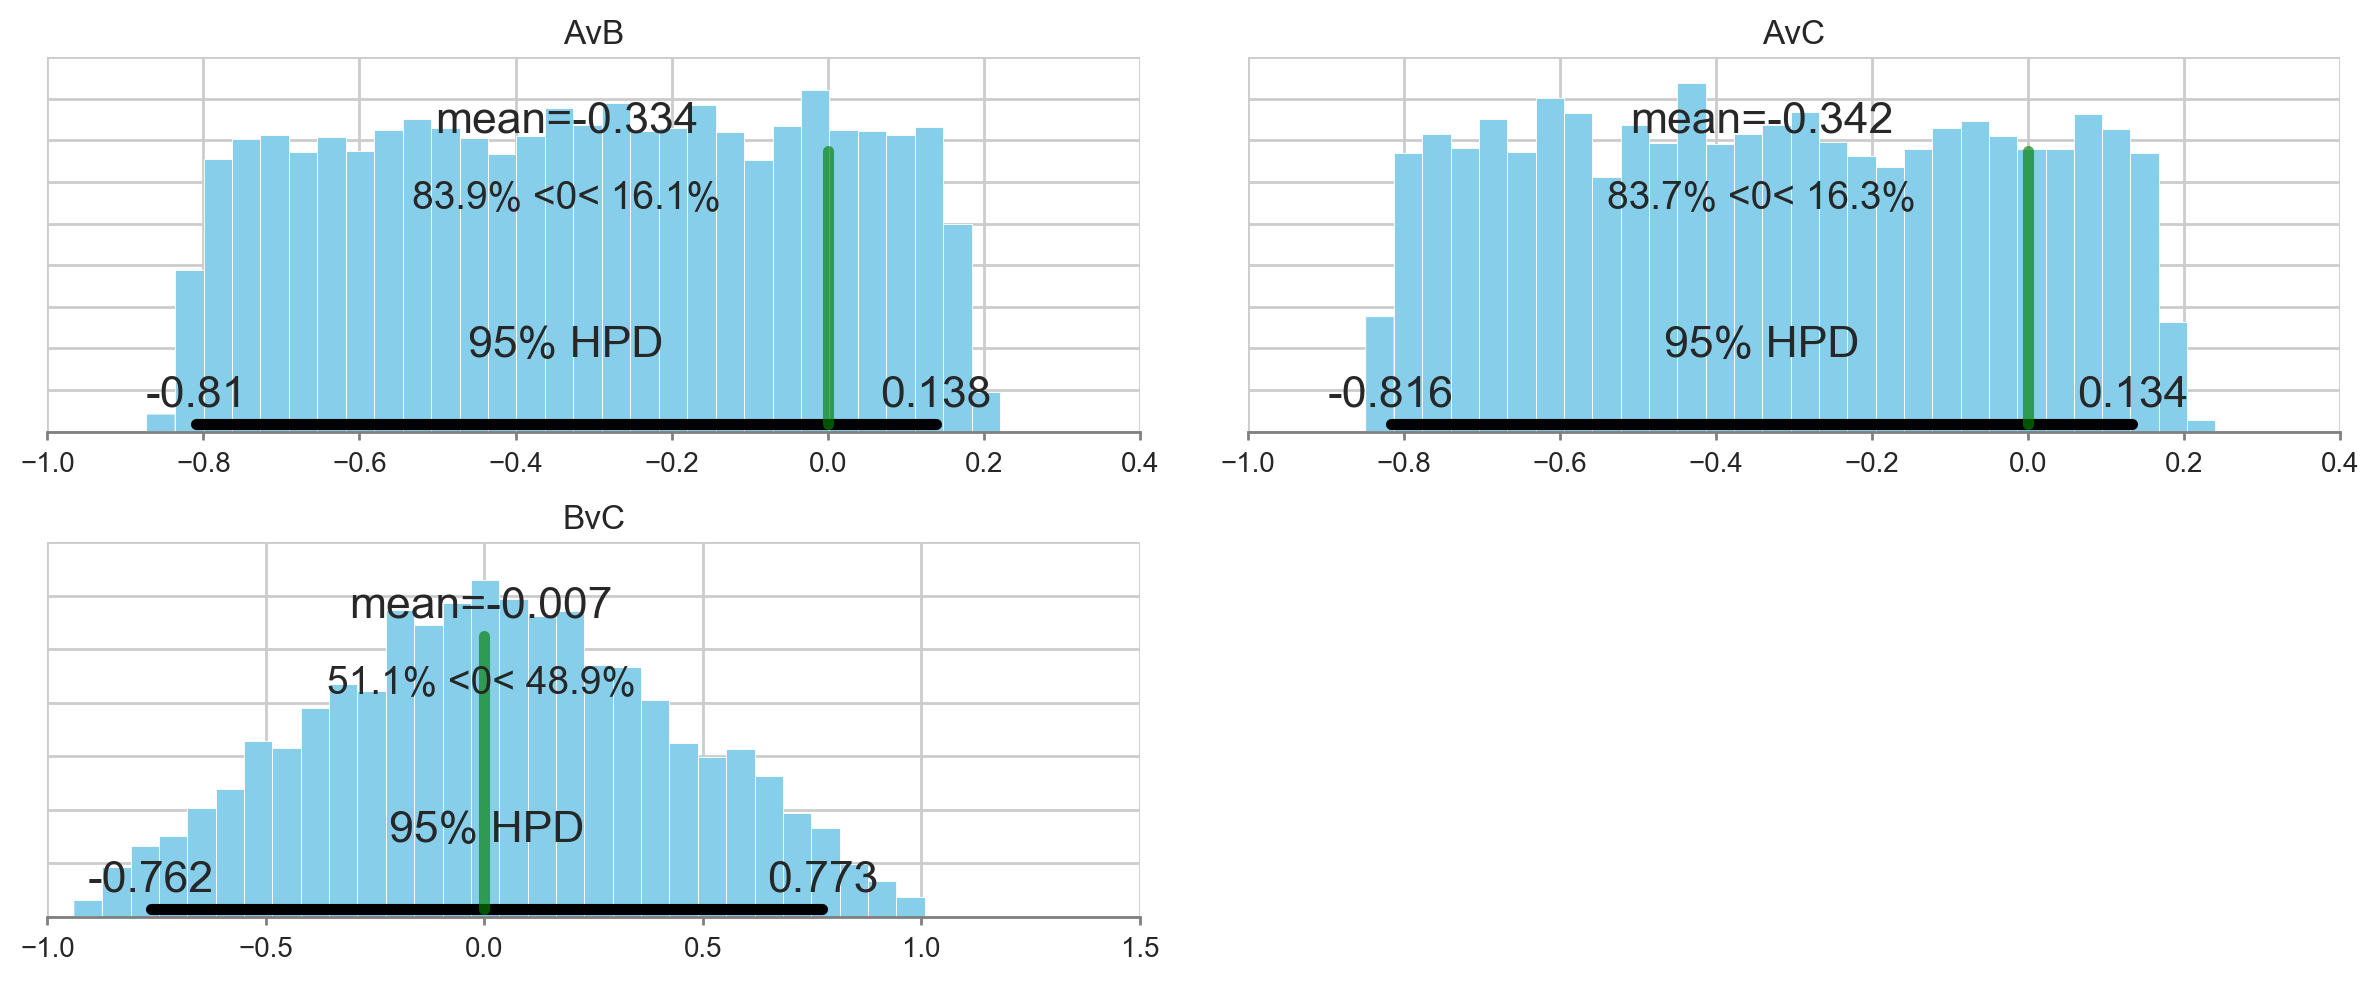

In [54]:
pm.plot_posterior(trace[100:], varnames=['AvB','AvC','BvC'], color='#87ceeb', ref_val=0)

---

## 6. Perform a hierarchical split test analysis for data through day 11

Thus far we have been constructing our models as **unpooled** models. This means that we are modeling the effect of arms A, B, and C on conversion rate independently. 

On the opposite end of this spectrum we would have a **pooled** model, where we would instead model A, B, and C with a single parameter. To do this, we would have to code the arms as numbers and then fit a single coefficient on them.

The benefit of an unpooled model like we have been using is that the effect of one arm does not have to be some fixed amount more than another one. For example, difference between rates in A and B can be small but the difference between A and C can be large. 

The benefit of a pooled model is that we share information. We don't want a pooled model for split test arms, but we can get the benefit of information sharing by building a **partial pooling** model. In partial pooling, each arm gets its own effect like in the unpooled model, but they _share a prior for how they are parameterized_. 

This means that if we have an arm with very few observations like arm C, our estimation for the conversion rate of arm C will be a combination of the overall conversion rate across arms and the specific conversion rate for just arm C's data. The less data any arm has, the more it's estimation will shrink towards the overall conversion rate. 

[See here for another detailed overview of hierarchical modeling and partial pooling with pymc3.](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)


---

### 6.1 Build and fit the hierarchical model

Now that we are building a hierarchical model, a few things are going to change. 

**1. Set up distributions for "group level" alpha and beta.**

We need to have a prior for the "overall" or "across-arm" alpha and beta values that will define their Beta distributions. 

...But let's back up for a second.

The prior/posterior for each arm is going to be modeled with a Beta distribution, which is a handy distribution for modeling probability of occurances or rates. The beta distribution, as you may recall, is parameterized by an alpha and beta parameter:

    alpha: successes + 1
    beta: failures + 1
    
Where successes will be conversions and failures will be non-conversions. 

Arm A, for example, can be set up in pymc3 like:

>```python
A_prior = pm.Beta('A_prior', alpha=?, beta=?)
```

As you can see, I've put question marks in the alpha and beta keyword assignments. If we set alpha=1 and beta=1, this would be equivalent to constructing a uniform prior for arm A, like we were doing before. We could set alpha and beta as higher values and have a stronger prior belief about conversions.

But what we need for our hierarchical model is that the three priors for arms A, B, and C _share_ a prior belief about what alpha and beta should be. So we want something like

>```python
A_prior = pm.Beta('A_prior', alpha=group_alpha, beta=group_beta)
B_prior = pm.Beta('B_prior', alpha=group_alpha, beta=group_beta)
```

Where `group_alpha` and `group_beta` are themselves prior distributions for likely values of alpha and beta. By having all the A, B, and C arm priors share the same alpha and beta prior beliefs, we tie them together and achieve partial pooling.

For example, imagine that we have very few observations of successes and failures (like with arm C). Because there are so few datapoints, the prior will not change much from the distribution defined by `group_alpha` and `group_beta`.

On the other hand, if we have a lot of observations like with arm A, the quantity of data will have a strong effect on the prior-to-posterior conversion and so our posterior will be more defined by the data tahn by `group_alpha` and `group_beta`.

This means that with little data, the rate distribution for an arm shrinks towards the overall group conversion rate.

To set up a group alpha and beta prior, we can use the `pm.Gamma()` distribution. The gamma distribution is strictly positive and in pymc we can define it with a mean and standard deviation. For the group level alpha, for example:

>```python
group_alpha = pm.Gamma('group_alpha', mu=10, sd=100)
```

The high standard deviation means that larger values are close in likelihood to smaller values, which is good since we want this to be fairly uninformative.

---

#### Construct the hierarchical model

Given all the information above, try to build the hierarchical model with group level alpha/beta priors and arm prior distributions defined by `pm.Beta` distributions that accept the group alpha and beta values as parameters.

The rest of the model structure should essetnially be the same as what you've been doing thus far.

In [55]:
current = data[data.day < 11]

In [57]:
with pm.Model() as day11_partial_pooling:
    
    group_alpha = pm.Uniform('group_alpha', lower=1, upper=1000)
    group_beta = pm.Uniform('group_beta', lower=1, upper=1000)
    
    A_prob = pm.Beta('A_prob', alpha=group_alpha, beta=group_beta)
    B_prob = pm.Beta('B_prob', alpha=group_alpha, beta=group_beta)
    C_prob = pm.Beta('C_prob', alpha=group_alpha, beta=group_beta)
    
    A = pm.Bernoulli('A', p=A_prob, observed=current[current.arm == 'A'].converted.values)
    B = pm.Bernoulli('B', p=A_prob, observed=current[current.arm == 'B'].converted.values)
    C = pm.Bernoulli('C', p=A_prob, observed=current[current.arm == 'C'].converted.values)
    
    AvB = pm.Deterministic('AvB', A_prob - B_prob)
    AvC = pm.Deterministic('AvC', A_prob - C_prob)
    BvC = pm.Deterministic('BvC', B_prob - C_prob)
    
    start = pm.find_MAP()
    trace = pm.sample(10000, start=start)

Applied interval-transform to group_alpha and added transformed group_alpha_interval_ to model.
Applied interval-transform to group_beta and added transformed group_beta_interval_ to model.
Applied logodds-transform to A_prob and added transformed A_prob_logodds_ to model.
Applied logodds-transform to B_prob and added transformed B_prob_logodds_ to model.
Applied logodds-transform to C_prob and added transformed C_prob_logodds_ to model.
Assigned NUTS to group_alpha_interval_
Assigned NUTS to group_beta_interval_
Assigned NUTS to A_prob_logodds_
Assigned NUTS to B_prob_logodds_
Assigned NUTS to C_prob_logodds_
INFO (theano.gof.compilelock): Refreshing lock /Users/Chris/.theano/compiledir_Darwin-16.4.0-x86_64-i386-64bit-i386-2.7.12-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/Chris/.theano/compiledir_Darwin-16.4.0-x86_64-i386-64bit-i386-2.7.12-64/lock_dir/lock
100%|██████████| 10000/10000 [06:31<00:00, 25.52it/s]


---

### 6.2 Plot the arm conversion rate distributions from your hierarchical model

---

### 6.3 Plot the distribution for arm C from the non-hierarchical (unpooled) model vs the hierarchical (pooled) model

NOTE: if the "trace" variable is named the same thing for the hierarchical model and unpooled model, then it probably overwrote the original trace. 

Make sure that the trace variable for your original and hierarchical models are named different things before doing this section (you may have to re-run the model, sorry!).

---

### 6.4 Plot the posterior difference variables with `pm.plot_posterior`

---

## 7. Make a hierarchical split test model for the whole dataset

Now do the same thing you just did above for the hierarchical model, but use the entire 21 days of data in the dataset.

---

### 7.1 Build the hierarchical model

---

### 7.2 Plot the conversion rate distributions for arms

---

### 7.3 Plot the posterior distributions for differences between arms

---

## [Bonus] 8. Add an effect of gender to your model

We can, of course, extend the model further to handle covariates in the dataset.

Let's say we wanted to model the effect of gender while estimating the conversion rate for each arm in the same model. If we were doing a logsitic legression, we could parameterize this as:

>```python
converted ~ intercept + gender + C(arm)
```

Where convert vs. not is predicted by a person's gender and what arm they were assigned to.

We can construct our Bayesian model in pymc3 (almost) just like this, but add in our hierarchical effect on the arm conversion rate!

---

#### The `pm.invlogit` function and re-definining effects with normal distributions

As you may recall, logistic regression frames the regression in terms of log-odds when minimizing the least squared loss function, the transforms the log-odds output back into probabilities. This transformation is called the "Logistic" or "Inverse Logit".

pymc3 has a function called `pm.invlogit()` that will perform this inverse logistic transformation on parameters. Using this, we can set up our prior distributions as normally distributed (as if we were representing them like coefficients in a regression), then convert them into probabilities to put in the `pm.Bernoulli()` likelihood portion of the model.

We only have two genders, so we can just set up a single prior for the coefficient on being male:

>```python
male_coef = pm.Normal('male', mu=0, sd=100)
```

This is a pretty uninformative prior on what we believe the effect of being male is. 

In previous models, we had our priors on the probability of conversion for arms set up as beta distributions or uniform distributions over the 0, 1 range. This is because we were having those priors directly represent probabilities. Now, however, we will be _converting_ our priors into probabilties using the `pm.invlogit` function, and so we will instead represent the group-level and arm-level priors as normally distributed effects.

The prior for arm A, for example, would now be:

>```python
A_prior = pm.Normal('A_coef', mu=arm_group_mean, sd=arm_group_sd)
```

Notice that instead of a group alpha and beta, we now have a group level normal distribution and standard deviation for the arms. We can set those up with a `pm.Normal` and `pm.Gamma`, respectively:

>```python
arm_group_mean = pm.Normal('arm_group_mean', mu=0, sd=100)
arm_group_sd = pm.Gamma('arm_group_sd', mu=10, sd=100)
```

When it comes time to convert all this to probabilities, you can feed it into the `pm.invlogit` function:

>```python
A_prob = pm.invlogit(male_coef * data.male.values + A_prior)
```

Which is now in terms of probability (just like the logistic regression does it). At this point it can neatly be fed into the Bernoulli likelihood just like we've done previously:

>```python
A = pm.Bernoulli('A', p=A_prob, observed=data[data.arm == "A"].converted.values)
```

---

### 8.1 Build and fit the hierarchical arm and gender model

---

### 8.2 Use `pm.plot_posterior` to examine the arm differences and gender coefficient distributions

---

### 8.3 Compare the arm C conversion distributions for the hierarchical model with just arms and hierarchical model with gender included

---

## 9. [Bonus] Build another bayesian hierarchical split test model with a different covariate

There are effects of the `age` and `fitness` variables on conversion rate that we have not explored in the lab.

If you're feeling ambitious, you can also model changes in the conversion rate by arm over the course of days. This will be a "random slope", which means a coefficient on the `day` variable that is different for each arm.